In [2]:
import datetime
import json
import os
import pickle
import time

import h5py
import matplotlib.pyplot as plt
import numpy as np
import xobjects as xo
import xpart as xp
import xtrack as xt
from tqdm import tqdm
import cupy as cp
from numba import njit

In [3]:
# import a module from ../xsuite_code
import sys
sys.path.append('../xsuite_code')
import normed_dynamic_indicators as ndi

In [5]:
@njit
def simple_gali(gali_matrix):
    if np.any(np.isnan(gali_matrix)):
        return np.nan
    else:
        _, s, _ = np.linalg.svd(gali_matrix)
        return np.prod(s)


@njit
def gali(gali_matrix):
    gali_matrix = np.transpose(gali_matrix, (2, 0, 1))
    gali = []
    for m in gali_matrix:
        gali.append(simple_gali(m))
    gali = np.asarray(gali)
    return gali

In [4]:
context = xo.ContextCupy()      # For CUDA GPUs
# context = xo.ContextCpu()         # For CPU

MASK_PATH = "../masks/"

selected_mask = "mask_b1_without_bb_21.json"

with open(f"../masks/{selected_mask}", "r") as fid:
    loaded_dct = json.load(fid)

line = xt.Line.from_dict(loaded_dct)
line.particle_ref = xp.Particles(mass0=xp.PROTON_MASS_EV, q0=1, p0c=7e12)
line.build_tracker(_context=context)
twiss = line.twiss()

Done loading line from dict.           


In [11]:
particles = line.build_particles(
                               zeta_norm=np.linspace(0, 4, 5), pzeta_norm=np.linspace(0, 4, 5),
                               x_norm=0, # in sigmas
                               y_norm=0, # in sigmas
                               nemitt_x=2.5e-6, nemitt_y=2.5e-6, _context=context)


In [12]:
twiss_data, w, w_inv = ndi.get_twiss_data(twiss, 2.5e-6, 2.5e-6, _context=context)
n_part = ndi.create_normed_placeholder(particles, twiss_data, w_inv, _context=context)
n_part

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  9.47643249e-14,
         0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00, -2.22103886e-15, -7.40346288e-15,
         0.00000000e+00, -5.92277031e-15],
       [ 0.00000000e+00,  7.40346288e-16, -2.96138515e-15,
        -5.92277031e-15, -1.18455406e-14],
       [ 0.00000000e+00,  1.00000000e+00,  2.00000000e+00,
         3.00000000e+00,  4.00000000e+00],
       [ 0.00000000e+00,  1.00000000e+00,  2.00000000e+00,
         3.00000000e+00,  4.00000000e+00]])

In [14]:
twiss.get_normalized_coordinates(particles, nemitt_x=2.5e-6, nemitt_y=2.5e-6,)["zeta_norm"]

array([0., 1., 2., 3., 4.])

In [23]:
disp = 1e-6

particles = line.build_particles(
                               zeta_norm=0, pzeta_norm=0,
                               x_norm=np.linspace(0, 4, 5), # in sigmas
                               y_norm=np.linspace(0, 4, 5), # in sigmas
                               nemitt_x=2.5e-6, nemitt_y=2.5e-6, _context=context)

particles_x = line.build_particles(
                               zeta_norm=disp, pzeta_norm=0,
                               x_norm=np.linspace(0, 4, 5), # in sigmas
                               y_norm=np.linspace(0, 4, 5), # in sigmas
                               nemitt_x=2.5e-6, nemitt_y=2.5e-6, _context=context)

particles_y = line.build_particles(
                               zeta_norm=0, pzeta_norm=0,
                               x_norm=np.linspace(0, 4, 5), # in sigmas
                               y_norm=np.linspace(0, 4, 5)+disp, # in sigmas
                               nemitt_x=2.5e-6, nemitt_y=2.5e-6, _context=context)

In [24]:
twiss_data, w, w_inv = ndi.get_twiss_data(twiss, 2.5e-6, 2.5e-6, _context=context)

In [25]:
n_part = ndi.create_normed_placeholder(particles, twiss_data, w_inv, _context=context)
n_part_x = ndi.create_normed_placeholder(particles_x, twiss_data, w_inv, _context=context)
n_part_y = ndi.create_normed_placeholder(particles_y, twiss_data, w_inv, _context=context)

In [27]:
n_part_x

array([[ 9.60226967e-20,  1.00000000e+00,  2.00000000e+00,
         3.00000000e+00,  4.00000000e+00],
       [-1.81313445e-18,  8.51687429e-15,  1.68602299e-14,
         2.64326761e-14,  3.40270095e-14],
       [-3.95387575e-20,  1.00000000e+00,  2.00000000e+00,
         3.00000000e+00,  4.00000000e+00],
       [ 2.45705136e-19, -3.70173144e-16,  7.40346288e-16,
        -1.48069258e-15, -1.48069258e-15],
       [ 1.00000000e-06,  1.00000000e-06,  1.00000000e-06,
         1.00000000e-06,  1.00000000e-06],
       [ 1.71407887e-21, -1.10519602e-20, -1.47899894e-21,
         8.10388846e-21, -4.66364429e-21]])

In [28]:
ndi.normalized_direction(n_part, n_part_x, particles.particle_id, particles_x.particle_id)

(array([[ 9.60226967e-14,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00],
        [-1.81313445e-12, -3.15225568e-10, -3.09441613e-10,
          6.82506734e-10, -3.12333590e-10],
        [-3.95387575e-14,  0.00000000e+00, -8.88178420e-10,
          4.44089210e-10, -8.88178420e-10],
        [ 2.45705136e-13,  0.00000000e+00,  1.48069258e-09,
         -1.48069258e-09,  0.00000000e+00],
        [ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
          1.00000000e+00,  1.00000000e+00],
        [ 1.71407887e-15,  1.71433182e-15,  1.71143669e-15,
          1.71888131e-15,  1.71722695e-15]]),
 array([1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06]))

In [30]:
np.matmul(w, w_inv)

array([[ 1.00000000e+00,  0.00000000e+00, -3.46944695e-18,
         2.22044605e-16,  0.00000000e+00,  0.00000000e+00],
       [-1.41983898e-18,  1.00000000e+00,  5.46437895e-17,
         0.00000000e+00, -2.75285708e-21,  1.73472348e-18],
       [-2.40451478e-18, -2.26832035e-16,  1.00000000e+00,
         1.19594435e-18,  0.00000000e+00,  6.93889390e-18],
       [ 4.40457133e-20,  4.33680869e-19,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00, -1.08420217e-19],
       [-1.73472348e-18,  0.00000000e+00, -5.09575021e-18,
        -3.46944695e-18,  1.00000000e+00, -1.15535294e-18],
       [ 2.38228016e-22,  6.77626358e-21,  9.52912066e-22,
        -4.02340650e-21,  5.93014182e-22,  1.00000000e+00]])

In [34]:
# evaluate w_inv using linalg.solve
w_inv_solve = np.linalg.solve(w, cp.eye(6))
w_inv_solve

array([[ 9.21209499e-02,  2.97984026e-08, -1.88699086e-03,
         1.35434108e-01, -4.12286927e-06,  2.28472518e-02],
       [ 2.05635611e-01,  1.08550817e+01, -1.03353553e-03,
         6.34957778e-02, -6.55104616e-06,  1.78786564e-01],
       [ 1.48424311e-03,  9.91895813e-02,  6.74732713e-02,
        -6.02890191e-08,  6.08260217e-06, -1.65284635e-03],
       [ 3.75816616e-04,  3.86841534e-02, -1.80177719e-01,
         1.48203858e+01, -3.90685486e-06, -5.45853138e-03],
       [-4.43683984e-04,  9.45680568e-03,  3.74013735e-05,
        -1.82961189e-03,  3.79085063e-02,  1.02853659e-06],
       [ 3.95991616e-06,  1.21086274e-03,  2.23545594e-05,
        -2.40330813e-03,  1.91586798e-04,  2.63793202e+01]])

In [35]:
np.matmul(w, w_inv_solve)

array([[ 1.00000000e+00, -2.77826807e-19, -1.77350170e-18,
         2.23853867e-16,  2.32934060e-21,  0.00000000e+00],
       [-6.39258454e-18,  1.00000000e+00,  5.46186713e-17,
        -3.15075081e-18, -2.81903153e-21,  3.46944695e-18],
       [-2.32504754e-18, -2.62789431e-16,  1.00000000e+00,
         1.98205710e-18, -2.48815928e-21,  0.00000000e+00],
       [ 5.08284133e-20,  2.58228582e-18, -2.09131380e-18,
         1.00000000e+00,  1.86942818e-22,  0.00000000e+00],
       [ 3.48223960e-18,  3.91173447e-18, -3.61407020e-18,
        -8.25077138e-19,  1.00000000e+00, -9.11570641e-19],
       [ 1.85288457e-22,  1.35525272e-20,  9.52912066e-22,
        -1.35525272e-20,  0.00000000e+00,  1.00000000e+00]])

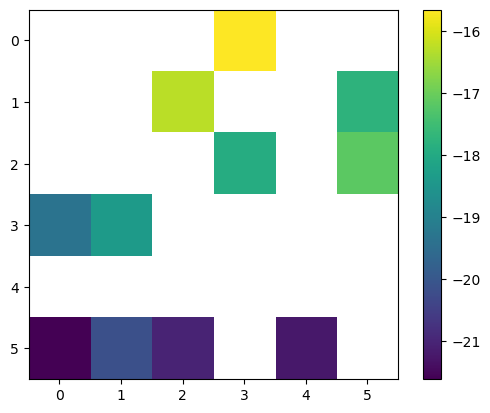

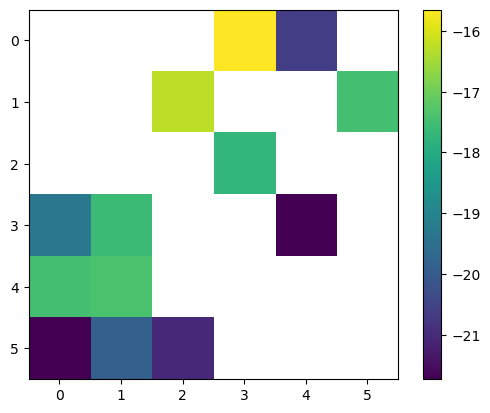

In [43]:
v1 = np.log10(np.matmul(w, w_inv)).get()
v2 = np.log10(np.matmul(w, w_inv_solve)).get()

v1[np.isclose(v1,0)] = np.nan
v2[np.isclose(v2,0)] = np.nan

plt.figure()
plt.imshow(v1)
plt.colorbar()
plt.figure()
plt.imshow(v2)
plt.colorbar()
